In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings('ignore')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
LEAGUES_DOMESTIC = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
LEAGUES_EXTRAS = ['POR-Primeira Liga']
SEASON = '2425'
MIN_MINUTES = 800

# Team colors
BARCELONA_COLORS = {'primary': '#004D98', 'secondary': '#004D98'}
SPORTING_COLORS = {'primary': '#7CFC00', 'secondary': '#FFFFFF'}

# Players
DF_PLAYERS = [
    {'name': 'Iñigo Martínez', 'search': 'Iñigo Martínez|Inigo Martinez', 'pos': 'DF', 'team': 'Barcelona'},
    {'name': 'Gonçalo Inácio', 'search': 'Gonçalo Inácio|Goncalo Inacio', 'pos': 'DF', 'team': 'Sporting CP'},
]

SAVE_PATH_BASE = "./inigo_vs_goncalo_radars_per90/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Database connection - Query domestic + extras
db = get_db_manager()

# Query domestic (Big 5)
league_domestic_str = "', '".join(LEAGUES_DOMESTIC)
query_domestic = f"""
SELECT unique_player_id, player_name, team, league, season, position, nationality, age, fbref_metrics, understat_metrics
FROM footballdecoded.players_domestic
WHERE league IN ('{league_domestic_str}') AND season = '{SEASON}'
"""

# Query extras (Portugal)
league_extras_str = "', '".join(LEAGUES_EXTRAS)
query_extras = f"""
SELECT unique_player_id, player_name, team, league, season, position, nationality, age, fbref_metrics, understat_metrics
FROM footballdecoded.players_extras
WHERE league IN ('{league_extras_str}') AND season = '{SEASON}'
"""

df_domestic = pd.read_sql(query_domestic, db.engine)
df_extras = pd.read_sql(query_extras, db.engine)
db.close()

df_raw = pd.concat([df_domestic, df_extras], ignore_index=True)
print(f"Extraídos: {df_raw.shape[0]} registros (domestic: {len(df_domestic)}, extras: {len(df_extras)})")

2026-01-30 12:32:05,200 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 12:32:06,115 - database.connection - INFO - Database connection successful


Extraídos: 3285 registros (domestic: 2722, extras: 563)


In [4]:
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(lambda x: x.get('minutes_played', 0) if x else 0) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('DF', case=False, na=False))
].copy()
print(f"Filtro {MIN_MINUTES}+ min + DF: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + DF: 795 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                if isinstance(raw_value, (int, float)):
                    values.append(float(raw_value))
                elif isinstance(raw_value, str):
                    try:
                        values.append(float(raw_value))
                    except:
                        values.append(np.nan)
                else:
                    values.append(np.nan)
            else:
                values.append(np.nan)
        if pd.Series(values).notna().sum() >= 5:
            result[key] = values
    return result

fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} | Understat: {understat_nums.shape[1]}")

FBref: 185 | Understat: 10


In [6]:
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%'
}

minutes_played = fbref_nums['minutes_played']

fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per90 = (fbref_per90.div(minutes_played, axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per90 = (understat_per90.div(minutes_played, axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)
print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

Per90: 174 + 10


In [7]:
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
df_final = pd.concat([df_filtered[base_cols], all_metrics, all_percentiles], axis=1)
print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

DataFrame final: 795 filas, 764 columnas


In [8]:
player_ids = {}
print("PLAYER SEARCH:")
for player_config in DF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    search_results = df_filtered[df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)]
    if len(search_results) > 0:
        for _, p in search_results.iterrows():
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"✓ {player_name}: {p['player_name']} ({p['team']})")
                break
    else:
        print(f"✗ {player_name}: NOT FOUND")

PLAYER SEARCH:
✓ Iñigo Martínez: Iñigo Martínez (Barcelona)
✓ Gonçalo Inácio: Gonçalo Inácio (Sporting CP)


In [9]:
# CB metrics per90
df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]
print(f"CB Metrics (per90): {len(df_metrics)}")

CB Metrics (per90): 10


In [10]:
# Comparison configuration
COMPARISON = {
    'name': 'Inigo_Martinez_vs_Goncalo_per90',
    'player1': 'Iñigo Martínez',
    'player2': 'Gonçalo Inácio', 
    'title': 'Iñigo Martínez vs Gonçalo Inácio (24/25) - per 90 min',
    'faces': ['../caras/iñigo.png', '../caras/goncalo.png'],
    'colors': [BARCELONA_COLORS['primary'], SPORTING_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")

COMPARISON: Iñigo Martínez vs Gonçalo Inácio (24/25) - per 90 min


RADAR GENERATION

Processing: Iñigo Martínez vs Gonçalo Inácio (24/25) - per 90 min
  Dataset: 725 players (DF)
  Teams: Barcelona vs Sporting CP
  ✓ Completed: Inigo_Martinez_vs_Goncalo_per90_combined.png


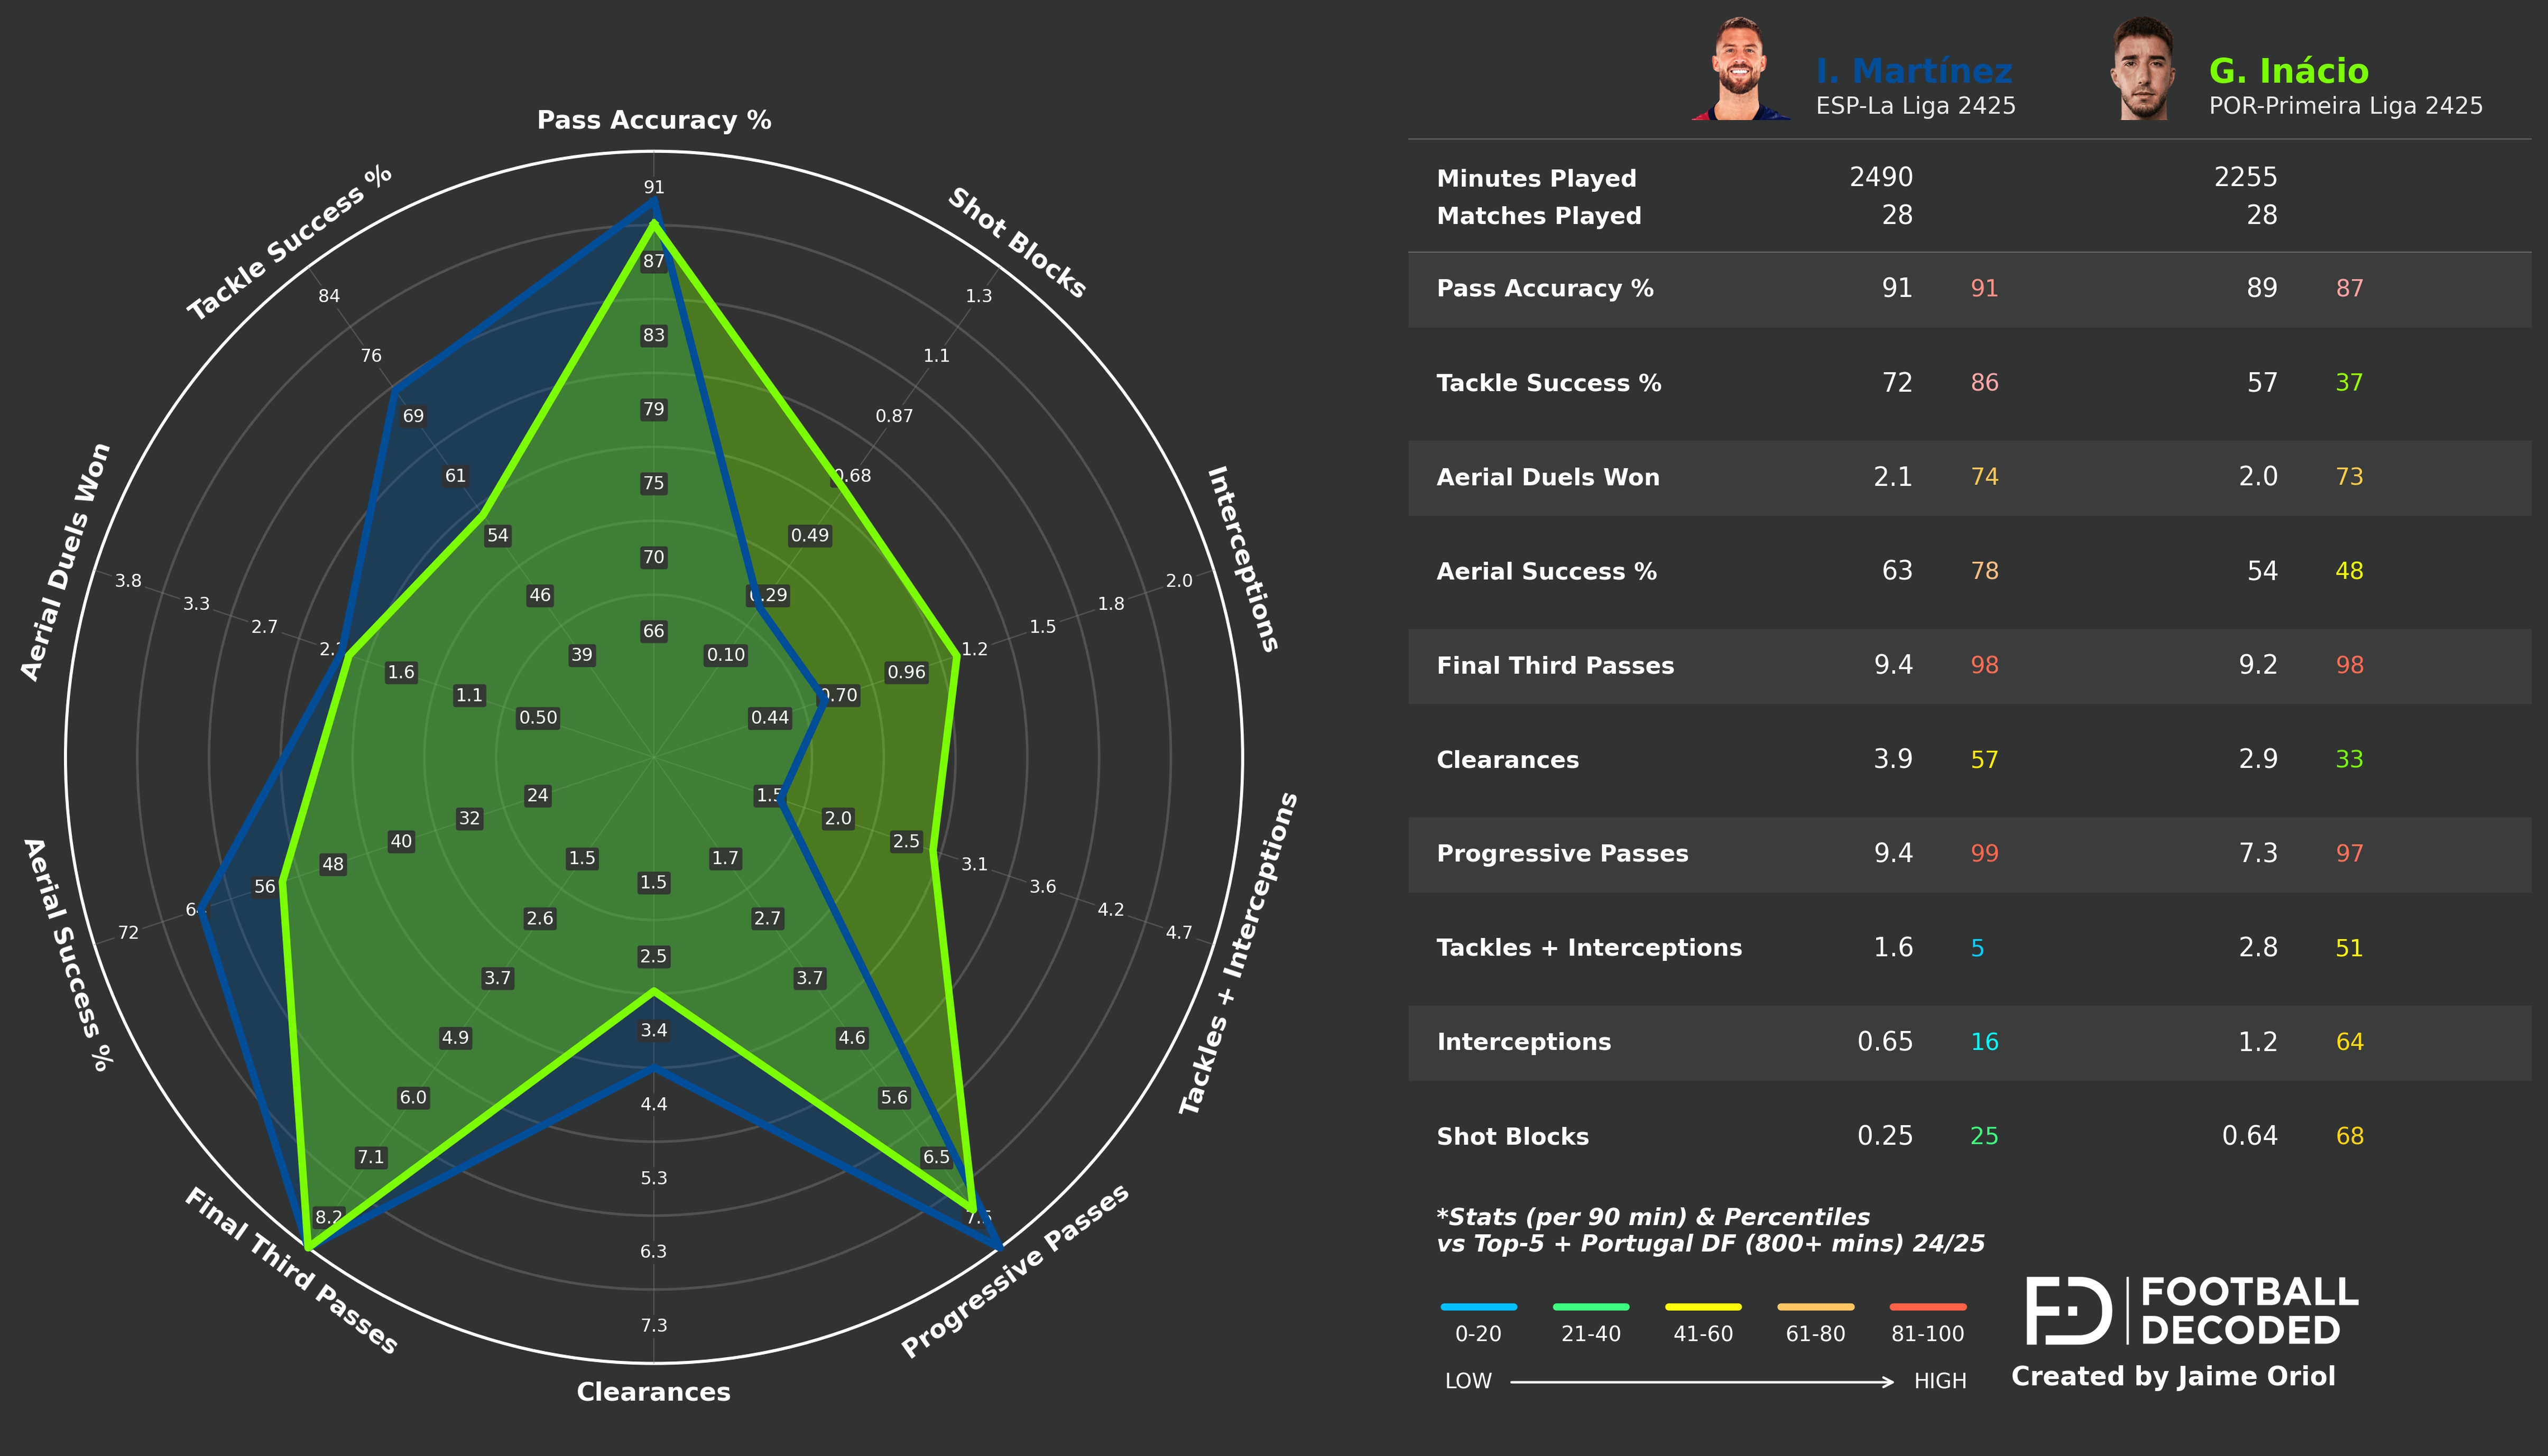

In [11]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    position_df = df_final[df_final['position'].str.startswith('DF')].copy()
    print(f"  Dataset: {position_df.shape[0]} players (DF)")
    
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_logos = {player1_team: faces[0], player2_team: faces[1]}
    print(f"  Teams: {player1_team} vs {player2_team}")
    
    try:
        create_player_radar(
            df_data=position_df, player_1_id=player1_id, player_2_id=player2_id,
            metrics=df_metrics, metric_titles=df_titles, team_colors=colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png", use_swarm=False, show_plot=False
        )
        
        create_stats_table(
            df_data=position_df, player_1_id=player1_id, player_2_id=player2_id,
            metrics=df_metrics, metric_titles=df_titles, team_colors=colors, team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 90 min) & Percentiles\nvs Top-5 + Portugal DF ({MIN_MINUTES}+ mins) 24/25", show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()